<a href="https://colab.research.google.com/github/juancforero/Data-Science-UB-Capstone/blob/main/Entrega_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from oandapyV20 import API
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.types import DateTime
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mysql.connector
import sqlalchemy


#TOKEN generado directamente en la pagina de oanda para seguridad y nunero de cuenta
api = API(access_token="xxxx")
accountID = "xxxxx"

#detalles de la cuenta en general desde posiciones abiertas y saldo hasta contractuales como si se puede usar apalancamiento
detalles = accounts.AccountDetails(accountID)

#nombre de los activos que queremos descargar
['FR40_EUR','EUR_GBP''EU50_EUR','DE30_EUR''EUR_USD','EUR_SGD','EUR_NOK','EUR_CAD','EUR_AUD','EUR_HKD','EUR_CHF']

#"imprime todos los instrumentos que puedo comprar y vender atra vez de oanda y por la API
r = accounts.AccountInstruments(accountID=accountID)
respuesta = api.request(r)
universo_instrumentos = [respuesta['instruments'][i]['name']for i in range(0,len(respuesta['instruments'][:]))]

In [ ]:
### parametros para la consecucion de precios
### vector donde guardaremos los precios optenidos dela api
precios_organisados = np.zeros((10000000,13))
fechas=[]
#fecha inicial de donde empezaremos a descargar precios
fecha_inicial = "2019-01-23T12:00:00Z"
#categoria de los precios
velas = ['bid','ask','mid']
# o= open, h = hight, l= low, c=close
tipos = ['o', 'h', 'l', 'c']
#volumne= cantidad de operaciones ejecutadas en el intrevalo de la granularidad
volumen = ['volume']
#granularidad:intervalos entre los cuales queremos los precios M5:5 minute candlesticks
granularidad = ["M1"]

contador = 0
try:
    for i in range(0,10000):
        if i > 0:
            #maxima fecha en la que vamos a pedir datos
            if fechas[-1][0:7] == "2021-05":
                break
            #la maxima cantidad de datos por la que se puede hacer la peticion al servidor es por 5000
#            fecha_inicial = precios['candles'][-1]['time'].replace(".000000000Z",".00Z")
            params = {"count": 5000,"granularity": granularidad,"from":fecha_inicial,"price":"BAM"}
            pr = instruments.InstrumentsCandles(instrument="EUR_CHF",params=params)
            precios = api.request(pr)
        else:
            params = {"count": 5000,"granularity": granularidad,"from":fecha_inicial,"price":"BAM"}
            pr = instruments.InstrumentsCandles(instrument="EUR_CHF",params=params)
            precios = api.request(pr)
            
        # recorremos cada uno de los precios para obtenere el precio maximo, minimo, medio del bid, ask y mid price   
        for j in range(0,len(precios['candles'])-1):
            fechas.append(precios['candles'][j]['time'])

            k = 0
            #recorremos todos el bid, ask y mid price
            for vela in enumerate(velas):
                #recorremos el precio de aperturaa,cierre, maximo y minimo
                for tipo in enumerate(tipos):   
                    precios_organisados[contador,k] = float(precios['candles'][j][vela[1]][tipo[1]])
                    k= k+1

            precios_organisados[contador,k] = float(precios['candles'][j]['volume'])
            contador = contador + 1
                
        #toma la ultima fecha dela peticion para que sea la nueva fecha desde donde comienza la consulta.            
        fecha_inicial = precios['candles'][-1]['time'].replace(".000000000Z",".00Z")
        print(fecha_inicial)

except:
    print("no funciono")

In [ ]:
df_fechas = pd.DataFrame(fechas, columns=['FECHAS'])
df_fechas.head(5)
columnas=['BID_OPEN','BID_HIGH','BID_LOW','BID_CLOSE',
          'ASK_OPEN','ASK_HIGH','ASK_LOW','ASK_CLOSE',
          'MID_OPEN','MID_HIGH','MID_LOW','MID_CLOSE',
          'VOLUME']
#convertimos el arreglo de precios en un rata frame y ponemos nombres a las columnas
df_precios_finales = pd.DataFrame(precios_organisados[0:len(fechas),:],columns=columnas)

#unimos el dataFrame de fechas con el data frame de precios
df_total = pd.concat([df_fechas,df_precios_finales],axis=1)
df_total.head(10)


#dado que ya tenemos los precios organizados en un dat frame, para no tener que volver a organizarlos
#se guardara toda la informacion en un base de datas realacional.
#abriumos la conexion con la base datos
database_username = 'xxxx'
database_password = 'xxxx'
database_ip       = '127.0.0.1'
database_name     = 'precios_activos'
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name), pool_recycle=1, pool_timeout=57600).connect()

#creamos el objeto sql que sera subido a la base datos y donde crearesmo la nueva tabla
df_total.to_sql(con=database_connection, name='EUR_CHF_5M',if_exists='replace', chunksize=5000) 
#cerramos la conexion
database_connection.close()

#grafico de la serie de precios    
plt.plot(precios_organisados[0:len(fechas),2]) # plotting by columns
plt.show()

#calculo de los retornos logaritmicos de los precios y el grafico de la serie de retornos de una de las columas
precios_organisados2 = precios_organisados[0:len(fechas),2]
ret_precios =  np.log(precios_organisados2[40::]/precios_organisados2[0:-40])
plt.plot(ret_precios) # plotting by columns
plt.show()


#intervalos de los retornos
q25, q75 = np.percentile(ret_precios,[.25,.75])
bin_width = 2*(q75 - q25)*len(ret_precios)**(-1/3)
bins = round((ret_precios.max() - ret_precios.min())/bin_width)

# Histogram:
# Bin it
n, bin_edges = np.histogram(ret_precios, bins)
# Normalize it, so that every bins value gives the probability of that bin
bin_probability = n/float(n.sum())
# Get the mid points of every bin
bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
# Compute the bin-width
bin_width = bin_edges[1]-bin_edges[0]
# Plot the histogram as a bar plot
plt.bar(bin_middles, bin_probability, width=bin_width)

plt.grid(True)
plt.xlim(-0.002,0.002)
plt.ylim(0,0.016)
plt.show()

In [ ]:
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mysql.connector
import sqlalchemy
import ta as tt


#conectarse a la base da datos para consultar las series de percios
mydb = mysql.connector.connect(
  host="localhost",
  user="xxx",
  password="xxx",
  database="precios_activos"
)

#activod que se quieren consutar dentro de la base de datos
series_activos = ['eur_usd_5m','eur_sgd_5m','eur_gbp_5m','eur_hkd_5m','eur_cad_5m']

#query sql para acceder a los datos de las tablas  de la base de datos
for activos in enumerate(series_activos):
    mycursor = mydb.cursor()
    
    if activos[0] == 0:        
        mycursor.execute(f"SELECT FECHAS, BID_CLOSE, MID_CLOSE,ASK_CLOSE, VOLUME FROM {activos[1]}")
        myresult = mycursor.fetchall()
        myresult = pd.DataFrame(myresult, columns=['FECHA',f"BID_CLOSE_{activos[1]}",f"MID_CLOSE_{activos[1]}",
                                                    f"BID_ASK_{activos[1]}",f"BID_CLOSE_{activos[1]}_VOLUME"])
    else:        
        mycursor.execute(f"SELECT  BID_CLOSE, MID_CLOSE, ASK_CLOSE, VOLUME FROM {activos[1]}")
        myresult2 = mycursor.fetchall()
        myresult2 = pd.DataFrame(myresult2, columns=[f"BID_CLOSE_{activos[1]}",f"MID_CLOSE_{activos[1]}",
                                                    f"BID_ASK_{activos[1]}",f"BID_CLOSE_{activos[1]}_VOLUME"])
        myresult = pd.concat([myresult,myresult2], axis=1)


bid_close_prices2 = myresult
bid_close_prices3 = bid_close_prices2
#escoger solo los datos de las series del bid
bid_close_names =['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_sgd_5m',
                              'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_hkd_5m',
                              'BID_CLOSE_eur_cad_5m']

In [ ]:
# calculo de indicadores tecnicos, en esta seccion se calcula el Exponential moving average con varias temporalidades
windowSize =[5,10,15,15,20,25,30]
for ew in enumerate(bid_close_names):
    for window in windowSize:
        bid_close_prices3[f"{ew[1]}_EWMA{window}"] = bid_close_prices3[f"{ew[1]}"].ewm(span=window, min_periods=window).mean()
    
    
# en esta seccion se calcula las bandad de bollinger, el rsi y los promedio moviles
bid_close=pd.DataFrame(bid_close_prices2['FECHA'])
for bid in enumerate(bid_close_names):
    bid_close[f"{bid[1]}"] = bid_close_prices2[f"{bid[1]}"]
    for window in windowSize:
        bid_close =pd.concat((bid_close,bid_close_prices3[f"{bid[1]}_EWMA{window}"]), axis=1)                 
    bid_close[f"{bid[1]}_volume"] = bid_close_prices2[f"{bid[1]}_VOLUME"]
    indicator_bb = tt.volatility.BollingerBands(bid_close_prices2[f"{bid[1]}"], window=20, window_dev=2)
    bid_close[f"{bid[1]}_moving_average"]  = indicator_bb.bollinger_mavg()
    bid_close[f"{bid[1]}_bolbandhind"]  =indicator_bb.bollinger_hband_indicator()
    bid_close[f"{bid[1]}_bolbandlind"]  =indicator_bb.bollinger_lband_indicator()
    bid_close[f"{bid[1]}_bolbandh"]  =indicator_bb.bollinger_hband()
    bid_close[f"{bid[1]}_bol_bandl"]  =indicator_bb.bollinger_lband()
    
    RSI = tt.momentum.rsi(bid_close_prices2[f"{bid[1]}"], window=14, fillna=True)
    bid_close[f"{bid[1]}_RSI"]  =RSI
    
    EMA = tt.trend.EMAIndicator(bid_close_prices2[f"{bid[1]}"], window = 14, fillna =True)
    bid_close[f"{bid[1]}_EMA"]  =EMA.ema_indicator() 
 
#graficos de todas las series utulizadas
plt.plot(bid_close_prices2['BID_CLOSE_eur_usd_5m'][1:1000000]) # plotting by columns
plt.plot(bid_close_prices2['BID_CLOSE_eur_sgd_5m'][1:1000000]) # plotting by columns
plt.plot(bid_close_prices2['BID_CLOSE_eur_gbp_5m'][1:1000000]) # plotting by columns
plt.plot(bid_close_prices2['BID_CLOSE_eur_hkd_5m'][1:1000000]) # plotting by columns
plt.plot(bid_close_prices2['BID_CLOSE_eur_cad_5m'][1:1000000]) # plotting by columns
plt.show()

bid_close3 =bid_close[850000::]

#creacion de un archivo csv con las series nescesarias que vamos a utilizar despues en el analisis
bid_close3.to_csv('path/TIME_SERIES_FINAL.CSV', sep=';', na_rep='', header=True)



In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
#informacion de la GPU que nos ha sido asiganda
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 17 22:24:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
#esta seccion tiene por objetuvo leer un archivo guardado directamente en google drive, apra este caso es el archivo que hemos generado arriba
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1GG5U7Cm6h6aXF1rB446Aro9aYMLLlGdC'}) # replace the id with id of file you want to access
downloaded.GetContentFile('TIME_SERIES_FINAL.CSV') 

In [ ]:
#leer el archivo csv creado y convertirlo en un dataframa
df2 = pd.read_csv('TIME_SERIES_FINAL.CSV',sep=';')
df2= df2[30::]

#observar los primeros 5 datos de la tabla
df2.head(5)

,Unnamed: 0,FECHA,BID_CLOSE_eur_usd_5m,BID_CLOSE_eur_usd_5m_EWMA5,BID_CLOSE_eur_usd_5m_EWMA10,BID_CLOSE_eur_usd_5m_EWMA15,BID_CLOSE_eur_usd_5m_EWMA15.1,BID_CLOSE_eur_usd_5m_EWMA20,BID_CLOSE_eur_usd_5m_EWMA25,BID_CLOSE_eur_usd_5m_EWMA30,BID_CLOSE_eur_usd_5m_volume,BID_CLOSE_eur_usd_5m_moving_average,BID_CLOSE_eur_usd_5m_bolbandhind,BID_CLOSE_eur_usd_5m_bolbandlind,BID_CLOSE_eur_usd_5m_bolbandh,BID_CLOSE_eur_usd_5m_bol_bandl,BID_CLOSE_eur_usd_5m_RSI,BID_CLOSE_eur_usd_5m_EMA,BID_CLOSE_eur_sgd_5m,BID_CLOSE_eur_sgd_5m_EWMA5,BID_CLOSE_eur_sgd_5m_EWMA10,BID_CLOSE_eur_sgd_5m_EWMA15,BID_CLOSE_eur_sgd_5m_EWMA15.1,BID_CLOSE_eur_sgd_5m_EWMA20,BID_CLOSE_eur_sgd_5m_EWMA25,BID_CLOSE_eur_sgd_5m_EWMA30,BID_CLOSE_eur_sgd_5m_volume,BID_CLOSE_eur_sgd_5m_moving_average,BID_CLOSE_eur_sgd_5m_bolbandhind,BID_CLOSE_eur_sgd_5m_bolbandlind,BID_CLOSE_eur_sgd_5m_bolbandh,BID_CLOSE_eur_sgd_5m_bol_bandl,BID_CLOSE_eur_sgd_5m_RSI,BID_CLOSE_eur_sgd_5m_EMA,BID_CLOSE_eur_gbp_5m,BID_CLOSE_eur_gbp_5m_EWMA5,BID_CLOSE_eur_gbp_5m_EWMA10,BID_CLOSE_eur_gbp_5m_EWMA15,BID_CLOSE_eur_gbp_5m_EWMA15.1,BID_CLOSE_eur_gbp_5m_EWMA20,...,BID_CLOSE_eur_gbp_5m_volume,BID_CLOSE_eur_gbp_5m_moving_average,BID_CLOSE_eur_gbp_5m_bolbandhind,BID_CLOSE_eur_gbp_5m_bolbandlind,BID_CLOSE_eur_gbp_5m_bolbandh,BID_CLOSE_eur_gbp_5m_bol_bandl,BID_CLOSE_eur_gbp_5m_RSI,BID_CLOSE_eur_gbp_5m_EMA,BID_CLOSE_eur_hkd_5m,BID_CLOSE_eur_hkd_5m_EWMA5,BID_CLOSE_eur_hkd_5m_EWMA10,BID_CLOSE_eur_hkd_5m_EWMA15,BID_CLOSE_eur_hkd_5m_EWMA15.1,BID_CLOSE_eur_hkd_5m_EWMA20,BID_CLOSE_eur_hkd_5m_EWMA25,BID_CLOSE_eur_hkd_5m_EWMA30,BID_CLOSE_eur_hkd_5m_volume,BID_CLOSE_eur_hkd_5m_moving_average,BID_CLOSE_eur_hkd_5m_bolbandhind,BID_CLOSE_eur_hkd_5m_bolbandlind,BID_CLOSE_eur_hkd_5m_bolbandh,BID_CLOSE_eur_hkd_5m_bol_bandl,BID_CLOSE_eur_hkd_5m_RSI,BID_CLOSE_eur_hkd_5m_EMA,BID_CLOSE_eur_cad_5m,BID_CLOSE_eur_cad_5m_EWMA5,BID_CLOSE_eur_cad_5m_EWMA10,BID_CLOSE_eur_cad_5m_EWMA15,BID_CLOSE_eur_cad_5m_EWMA15.1,BID_CLOSE_eur_cad_5m_EWMA20,BID_CLOSE_eur_cad_5m_EWMA25,BID_CLOSE_eur_cad_5m_EWMA30,BID_CLOSE_eur_cad_5m_volume,BID_CLOSE_eur_cad_5m_moving_average,BID_CLOSE_eur_cad_5m_bolbandhind,BID_CLOSE_eur_cad_5m_bolbandlind,BID_CLOSE_eur_cad_5m_bolbandh,BID_CLOSE_eur_cad_5m_bol_bandl,BID_CLOSE_eur_cad_5m_RSI,BID_CLOSE_eur_cad_5m_EMA
30,850030,2018-04-26T06:45:00.000000000Z,1.21853,1.218122,1.217914,1.217824,1.217824,1.217772,1.217736,1.217706,259.0,1.217682,1.0,0.0,1.218351,1.217013,66.490471,1.217838,1.61804,1.618327,1.618333,1.618330,1.618330,1.618341,1.618363,1.618390,321.0,1.618278,0.0,0.0,1.618994,1.617562,45.910168,1.618330,0.88105,0.880791,0.880538,0.880390,0.880390,0.880296,...,65.0,0.880181,1.0,0.0,0.880969,0.879392,78.613584,0.880415,9.59703,9.596156,9.595310,9.594824,9.594824,9.594566,9.594464,9.594460,17.0,9.594078,1.0,0.0,9.596990,9.591167,64.469071,9.594900,1.55679,1.556564,1.556421,1.556370,1.556370,1.556347,1.556331,1.556317,148.0,1.556317,0.0,0.0,1.556873,1.555761,61.464845,1.556377
31,850031,2018-04-26T06:50:00.000000000Z,1.21873,1.218325,1.218062,1.217937,1.217937,1.217863,1.217812,1.217772,222.0,1.217743,1.0,0.0,1.218547,1.216939,69.023792,1.217957,1.61788,1.618178,1.618251,1.618274,1.618274,1.618297,1.618325,1.618357,180.0,1.618235,0.0,0.0,1.618938,1.617532,44.174015,1.618270,0.88130,0.880961,0.880677,0.880504,0.880504,0.880392,...,61.0,0.880256,1.0,0.0,0.881162,0.879349,81.742261,0.880533,9.59545,9.595921,9.595335,9.594902,9.594902,9.594650,9.594540,9.594524,52.0,9.594281,0.0,0.0,9.596974,9.591588,54.753615,9.594974,1.55671,1.556613,1.556474,1.556413,1.556413,1.556382,1.556360,1.556342,128.0,1.556316,0.0,0.0,1.556871,1.555762,59.130258,1.556421
32,850032,2018-04-26T06:55:00.000000000Z,1.21782,1.218156,1.218018,1.217923,1.217923,1.217859,1.217813,1.217775,349.0,1.217759,0.0,0.0,1.218556,1.216961,50.366148,1.217938,1.61827,1.618209,1.618254,1.618273,1.618273,1.618295,1.618321,1.618351,235.0,1.618223,0.0,0.0,1.618915,1.617531,49.215301,1.618270,0.88127,0.881064,0.880785,0.880600,0.880600,0.880475,...,97.0,0.880327,0.0,0

In [ ]:
#longitud de la tabla en filas
print(len(df2))
#ver el nombre de las columas
df2.columns

224755


Index(['Unnamed: 0', 'FECHA', 'BID_CLOSE_eur_usd_5m',
       'BID_CLOSE_eur_usd_5m_EWMA5', 'BID_CLOSE_eur_usd_5m_EWMA10',
       'BID_CLOSE_eur_usd_5m_EWMA15', 'BID_CLOSE_eur_usd_5m_EWMA15.1',
       'BID_CLOSE_eur_usd_5m_EWMA20', 'BID_CLOSE_eur_usd_5m_EWMA25',
       'BID_CLOSE_eur_usd_5m_EWMA30', 'BID_CLOSE_eur_usd_5m_volume',
       'BID_CLOSE_eur_usd_5m_moving_average',
       'BID_CLOSE_eur_usd_5m_bolbandhind', 'BID_CLOSE_eur_usd_5m_bolbandlind',
       'BID_CLOSE_eur_usd_5m_bolbandh', 'BID_CLOSE_eur_usd_5m_bol_bandl',
       'BID_CLOSE_eur_usd_5m_RSI', 'BID_CLOSE_eur_usd_5m_EMA',
       'BID_CLOSE_eur_sgd_5m', 'BID_CLOSE_eur_sgd_5m_EWMA5',
       'BID_CLOSE_eur_sgd_5m_EWMA10', 'BID_CLOSE_eur_sgd_5m_EWMA15',
       'BID_CLOSE_eur_sgd_5m_EWMA15.1', 'BID_CLOSE_eur_sgd_5m_EWMA20',
       'BID_CLOSE_eur_sgd_5m_EWMA25', 'BID_CLOSE_eur_sgd_5m_EWMA30',
       'BID_CLOSE_eur_sgd_5m_volume', 'BID_CLOSE_eur_sgd_5m_moving_average',
       'BID_CLOSE_eur_sgd_5m_bolbandhind', 'BID_CLOSE_eur_sg

In [ ]:
#tomamos solo las columas que nos interesan para el analisis de la serue financiera del EUR_USD
import numpy as np
df = df2[['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandhind','BID_CLOSE_eur_usd_5m_bolbandlind','BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandhind','BID_CLOSE_eur_sgd_5m_bolbandlind','BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandhind','BID_CLOSE_eur_gbp_5m_bolbandlind','BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandhind','BID_CLOSE_eur_hkd_5m_bolbandlind','BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandhind','BID_CLOSE_eur_cad_5m_bolbandlind','BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']]

df = df[80000:224000]
df.reset_index(inplace=True)
print(len(df))
df.head(5)

144000


,index,BID_CLOSE_eur_usd_5m,BID_CLOSE_eur_usd_5m_EWMA10,BID_CLOSE_eur_usd_5m_EWMA20,BID_CLOSE_eur_usd_5m_EWMA30,BID_CLOSE_eur_usd_5m_volume,BID_CLOSE_eur_usd_5m_moving_average,BID_CLOSE_eur_usd_5m_bolbandhind,BID_CLOSE_eur_usd_5m_bolbandlind,BID_CLOSE_eur_usd_5m_bolbandh,BID_CLOSE_eur_usd_5m_bol_bandl,BID_CLOSE_eur_usd_5m_RSI,BID_CLOSE_eur_usd_5m_EMA,BID_CLOSE_eur_sgd_5m,BID_CLOSE_eur_sgd_5m_EWMA10,BID_CLOSE_eur_sgd_5m_EWMA20,BID_CLOSE_eur_sgd_5m_EWMA30,BID_CLOSE_eur_sgd_5m_volume,BID_CLOSE_eur_sgd_5m_moving_average,BID_CLOSE_eur_sgd_5m_bolbandhind,BID_CLOSE_eur_sgd_5m_bolbandlind,BID_CLOSE_eur_sgd_5m_bolbandh,BID_CLOSE_eur_sgd_5m_bol_bandl,BID_CLOSE_eur_sgd_5m_RSI,BID_CLOSE_eur_sgd_5m_EMA,BID_CLOSE_eur_gbp_5m,BID_CLOSE_eur_gbp_5m_EWMA10,BID_CLOSE_eur_gbp_5m_EWMA20,BID_CLOSE_eur_gbp_5m_EWMA30,BID_CLOSE_eur_gbp_5m_volume,BID_CLOSE_eur_gbp_5m_moving_average,BID_CLOSE_eur_gbp_5m_bolbandhind,BID_CLOSE_eur_gbp_5m_bolbandlind,BID_CLOSE_eur_gbp_5m_bolbandh,BID_CLOSE_eur_gbp_5m_bol_bandl,BID_CLOSE_eur_gbp_5m_RSI,BID_CLOSE_eur_gbp_5m_EMA,BID_CLOSE_eur_hkd_5m,BID_CLOSE_eur_hkd_5m_EWMA10,BID_CLOSE_eur_hkd_5m_EWMA20,BID_CLOSE_eur_hkd_5m_EWMA30,BID_CLOSE_eur_hkd_5m_volume,BID_CLOSE_eur_hkd_5m_moving_average,BID_CLOSE_eur_hkd_5m_bolbandhind,BID_CLOSE_eur_hkd_5m_bolbandlind,BID_CLOSE_eur_hkd_5m_bolbandh,BID_CLOSE_eur_hkd_5m_bol_bandl,BID_CLOSE_eur_hkd_5m_RSI,BID_CLOSE_eur_hkd_5m_EMA,BID_CLOSE_eur_cad_5m,BID_CLOSE_eur_cad_5m_EWMA10,BID_CLOSE_eur_cad_5m_EWMA20,BID_CLOSE_eur_cad_5m_EWMA30,BID_CLOSE_eur_cad_5m_volume,BID_CLOSE_eur_cad_5m_moving_average,BID_CLOSE_eur_cad_5m_bolbandhind,BID_CLOSE_eur_cad_5m_bolbandlind,BID_CLOSE_eur_cad_5m_bolbandh,BID_CLOSE_eur_cad_5m_bol_bandl,BID_CLOSE_eur_cad_5m_RSI,BID_CLOSE_eur_cad_5m_EMA
0,80030,1.11784,1.117998,1.117693,1.117268,44.0,1.117840,0.0,0.0,1.118641,1.117038,57.406858,1.117907,1.53896,1.539561,1.539477,1.539398,317.0,1.539422,0.0,0.0,1.540277,1.538567,41.463364,1.539534,0.88327,0.883221,0.883063,0.882898,22.0,0.883131,0.0,0.0,0.883489,0.882772,59.969645,0.883159,8.76022,8.760772,8.760906,8.761058,43.0,8.760604,0.0,0.0,8.761959,8.759250,43.294066,8.760812,1.50617,1.506147,1.506210,1.506297,259.0,1.506080,0.0,0.0,1.506614,1.505547,47.856915,1.506158
1,80031,1.11767,1.117939,1.117691,1.117293,45.0,1.117864,0.0,0.0,1.118612,1.117116,54.319707,1.117875,1.53894,1.539448,1.539426,1.539369,183.0,1.539427,0.0,0.0,1.540269,1.538586,41.157264,1.539455,0.88327,0.883230,0.883083,0.882922,24.0,0.883144,0.0,0.0,0.883502,0.882786,59.969645,0.883173,8.75889,8.760430,8.760714,8.760918,21.0,8.760466,0.0,1.0,8.761925,8.759008,35.376877,8.760556,1.50654,1.506219,1.506241,1.506312,325.0,1.506109,0.0,0.0,1.506676,1.505542,54.712956,1.506209
2,80032,1.11772,1.117899,1.117694,1.117321,30.0,1.117904,0.0,0.0,1.118519,1.117289,55.084764,1.117854,1.53895,1.539358,1.539380,1.539342,232.0,1.539431,0.0,0.0,1.540264,1.538598,41.390246,1.539388,0.88309,0.883205,0.883083,0.882933,28.0,0.883145,0.0,0.0,0.883502,0.882787,53.533371,0.883162,8.75933,8.760230,8.760582,8.760815,14.0,8.760357,0.0,0.0,8.761814,8.758901,39.329675,8.760392,1.50684,1.506332,1.506298,1.506346,289.0,1.506148,1.0,0.0,1.506797,1.505500,59.376905,1.506293
3,80033,1.11772,1.117866,1.117696,1.117347,51.0,1.117927,0.0,0.0,1.118477,1.117376,55.084764,1.117837,1.53895,1.539283,1.539339,1.539317,155.0,1.539427,0.0,0.0,1.540268,1.538587,41.390246,1.539329,0.88316,0.883197,0.883091,0.882948,28.0,0.883143,0.0,0.0,0.883499,0.882786,55.532126,0.883162,8.75937,8.760073,8.760467,8.760722,10.0,8.760277,0.0,0.0,8.761764,8.758790,39.690829,8.760256,1.50670,1.506399,1.506337,1.506369,200.0,1.506172,0.0,0.0,1.506864,1.505481,56.454951,1.506347
4,80034,1.11779,1.117852,1.117705,1.117375,49.0,1.117930,0.0,0.0,1.118476,1.117384,56.273823,1.117830,1.53898,1.539228,1.539305,1.539295,196.0,1.539422,0.0,0.0,1.540272,1.538572,42.186679,1.539283,0.88307,0.883174,0.883089,0.882956,30.0,0.883144,0.0,0.0,0.883499,0.882788,52.410601,0.883150,8.75937,8.759945,8.760362,8.760635,14.0,8.760223,0.0

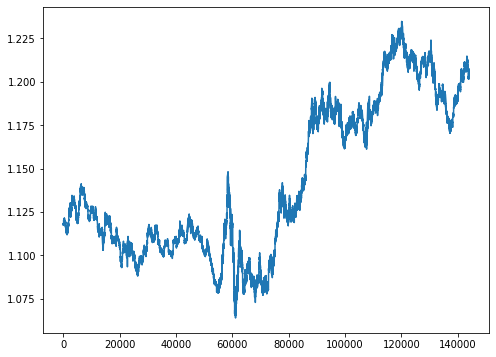

In [ ]:
#observar la serie de datos
plt.plot(df['BID_CLOSE_eur_usd_5m'])
plt.show()

In [ ]:
df = df[['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandhind','BID_CLOSE_eur_usd_5m_bolbandlind','BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandhind','BID_CLOSE_eur_sgd_5m_bolbandlind','BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandhind','BID_CLOSE_eur_gbp_5m_bolbandlind','BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandhind','BID_CLOSE_eur_hkd_5m_bolbandlind','BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandhind','BID_CLOSE_eur_cad_5m_bolbandlind','BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']]
df_escalado = df

In [ ]:
# utilizamos el el paquete de sklearn para reescalr los datos para que queden entre cero y uno, dado que son series finacnieras no queremos precios negativos por dejabo de cero, 
#por lo cual consideramos conveniente no rescalar los datos al rededor del cero. luego haremos un edtudio con los datgo centrados alrededor del cero, utilizando retornos.

from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(df_escalado)
transformer
MaxAbsScaler()
df = transformer.transform(df_escalado)

columnas = ['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandhind','BID_CLOSE_eur_usd_5m_bolbandlind','BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandhind','BID_CLOSE_eur_sgd_5m_bolbandlind','BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandhind','BID_CLOSE_eur_gbp_5m_bolbandlind','BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandhind','BID_CLOSE_eur_hkd_5m_bolbandlind','BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandhind','BID_CLOSE_eur_cad_5m_bolbandlind','BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']
df = pd.DataFrame(df,columns=columnas)

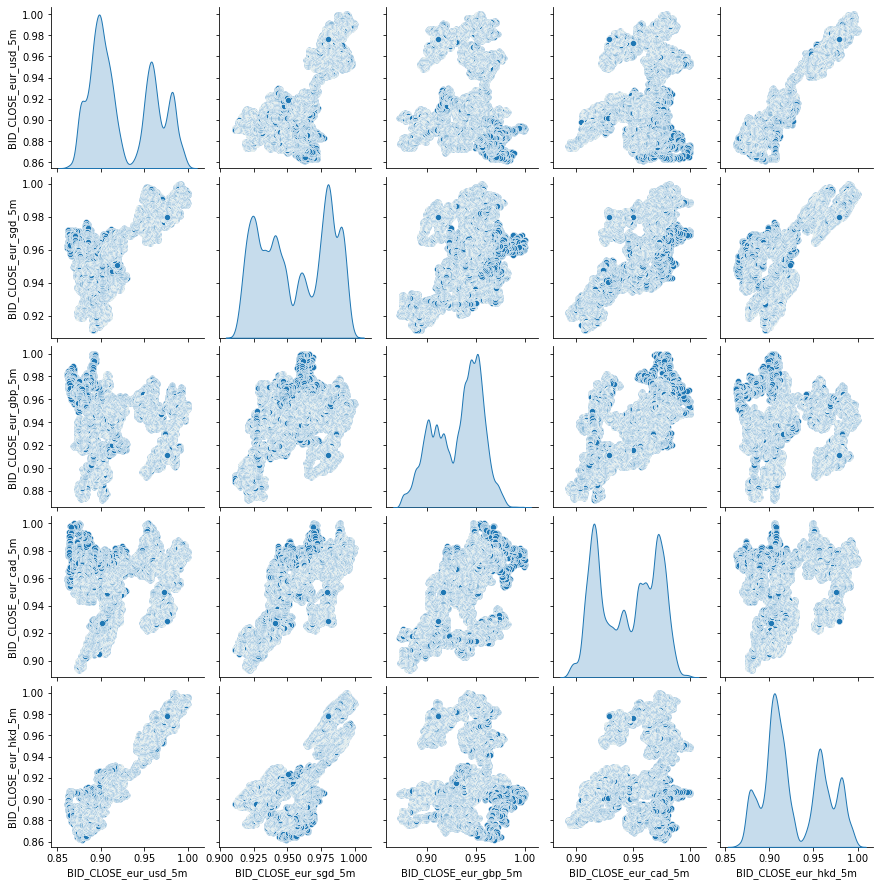

In [ ]:
#grafico descriptivo de las distribuciones de los activos
sns.pairplot(df[["BID_CLOSE_eur_usd_5m", "BID_CLOSE_eur_sgd_5m", "BID_CLOSE_eur_gbp_5m", 
                 'BID_CLOSE_eur_cad_5m',"BID_CLOSE_eur_hkd_5m"]], diag_kind="kde")

In [ ]:
#estadsiticas descritpivas de las 5 principales series
df_describe =df[["BID_CLOSE_eur_usd_5m", "BID_CLOSE_eur_sgd_5m", "BID_CLOSE_eur_gbp_5m", 
                 'BID_CLOSE_eur_cad_5m',"BID_CLOSE_eur_hkd_5m"]]
df_describe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BID_CLOSE_eur_usd_5m,144000.0,0.925605,0.036107,0.861562,0.896119,0.911442,0.959159,1.0
BID_CLOSE_eur_sgd_5m,144000.0,0.955972,0.025268,0.911297,0.932517,0.956334,0.980088,1.0
BID_CLOSE_eur_gbp_5m,144000.0,0.931720,0.024074,0.872102,0.910762,0.937716,0.950982,1.0
BID_CLOSE_eur_cad_5m,144000.0,0.944944,0.025670,0.893220,0.918467,0.948316,0.969388,1.0
BID_CLOSE_eur_hkd_5m,144000.0,0.928235,0.034094,0.861939,0.902814,0.916310,0.958724,1.0


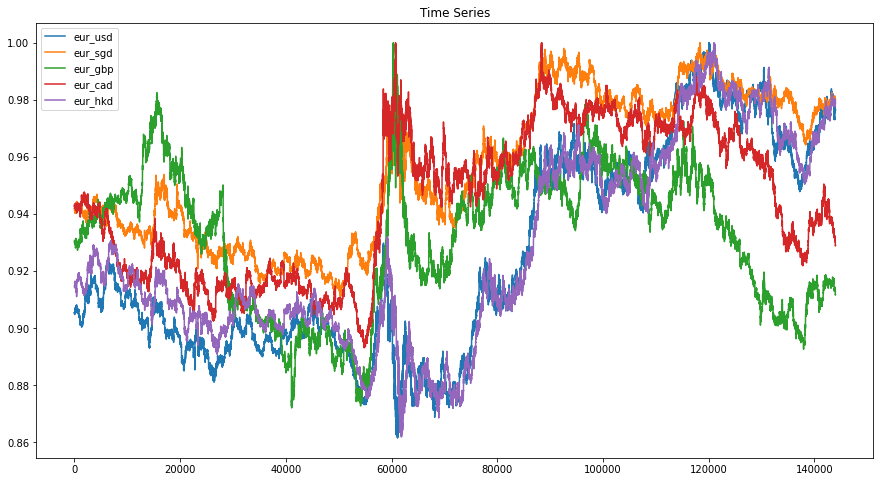

In [ ]:
#grafico de las 5 series principales escaladas entre 0 y 1
plt.figure(figsize=(15,8))
plt.title(label="Time Series")
plt.plot(df['BID_CLOSE_eur_usd_5m'],label="eur_usd")
plt.plot(df['BID_CLOSE_eur_sgd_5m'],label="eur_sgd")  
plt.plot(df['BID_CLOSE_eur_gbp_5m'],label="eur_gbp")
plt.plot(df['BID_CLOSE_eur_cad_5m'],label="eur_cad")
plt.plot(df['BID_CLOSE_eur_hkd_5m'],label="eur_hkd")
plt.legend()
plt.show()

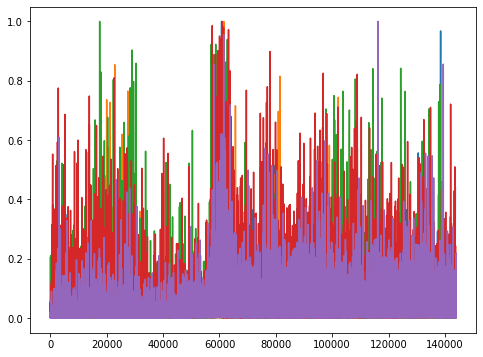

In [ ]:
#grafico de los volumnes de negocion por tipo de activo
plt.plot(df['BID_CLOSE_eur_usd_5m_volume'])
plt.plot(df['BID_CLOSE_eur_sgd_5m_volume'])  
plt.plot(df['BID_CLOSE_eur_gbp_5m_volume'])
plt.plot(df['BID_CLOSE_eur_cad_5m_volume'])
plt.plot(df['BID_CLOSE_eur_hkd_5m_volume'])
plt.show()

In [ ]:
#estadistica descriptiva de todas slas varaibles otulizadas para el estudio
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BID_CLOSE_eur_usd_5m,144000.0,0.925605,0.036107,0.861562,0.896119,0.911442,0.959159,1.0
BID_CLOSE_eur_usd_5m_EWMA10,144000.0,0.925943,0.036117,0.862517,0.896444,0.911756,0.959496,1.0
BID_CLOSE_eur_usd_5m_EWMA20,144000.0,0.926064,0.036119,0.863112,0.896566,0.911866,0.959627,1.0
BID_CLOSE_eur_usd_5m_EWMA30,144000.0,0.926181,0.036121,0.863714,0.896655,0.911960,0.959751,1.0
BID_CLOSE_eur_usd_5m_volume,144000.0,0.040071,0.049793,0.000159,0.006844,0.020213,0.058412,1.0
BID_CLOSE_eur_usd_5m_moving_average,144000.0,0.926068,0.036120,0.862958,0.896575,0.911862,0.959637,1.0
BID_CLOSE_eur_usd_5m_bolbandhind,144000.0,0.057694,0.233166,0.000000,0.000000,0.000000,0.000000,1.0
BID_CLOSE_eur_usd_5m_bolbandlind,144000.0,0.059049,0.235716,0.000000,0.000000,0.000000,0.000000,1.0
BID_CLOSE_eur_usd_5m_bolbandh,144000.0,0.925585,0.036099,0.862964,0.895979,0.911405,0.959070,1.0
BID_CLOSE_eur_usd_5m_bol_bandl,144000.0,0.926000,0.036128,0.861850,0.896645,0.911750,0.959533,1.0


In [ ]:
#divisimos el set de datos general en train test y validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


print(n)
print(num_features)
print(len(train_df))
print(len(val_df))
print(len(test_df))

144000
60
100800
28800
14400


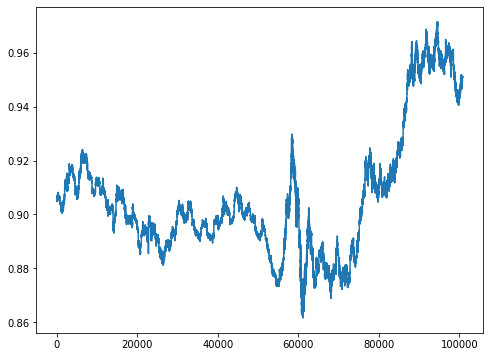

In [ ]:
#Grafico de los datos de ventrenamiento
plt.plot(train_df['BID_CLOSE_eur_usd_5m'])
plt.show()

In [ ]:
#funcion para crear los data sets con los coeficientes autorgresivos de la se la serie mas los de las otras series de tal manera que estene n un fromato legible para las redes.
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
#variblle que nos indica cuantoas variables hacia atras en el tiempo queremos utilizar para predecir el siguiente vcalor
time_steps = 15

# reshape to [samples, time_steps, n_features]
#creamos los datasets con las etiquetas para el entranimiento la validacion y el test del modelo
X_train, y_train = create_dataset(train_df , train_df.BID_CLOSE_eur_usd_5m, time_steps)
X_test, y_test = create_dataset(val_df, val_df.BID_CLOSE_eur_usd_5m, time_steps)
X_val, y_val = create_dataset(test_df, test_df.BID_CLOSE_eur_usd_5m, time_steps)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(100785, 15, 60) (100785,)
(28785, 15, 60) (28785,)
(14385, 15, 60) (14385,)


In [ ]:
#dado que ya ya tenemos los ejemplos organizados con cada una imput por un autput, podemos mesclarlos de manera aleatoria para que el modelos no aprenda una tendencia en especifico
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [ ]:
#Funcion de compilacion del modelo, en este espeficamos la funcion de perdida el numero de epocas el optimizador y otras variables
MAX_EPOCHS =70
def compile_and_fit(model, X_train, y_train, y_test , patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

#  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
 #    lambda epoch: 1e-8 * 10**(epoch / 20))
  optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  history = model.fit(X_train, y_train, 
                      batch_size=64,
#                      validation_data=y_test,
                      validation_split=0.1,
                      epochs=MAX_EPOCHS)#, callbacks=[lr_schedule])
  return history

In [ ]:
#modelo con capas LSTM 
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(900, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(600, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(350, return_sequences=False)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
#compilar el modelo y guardar los resultados del modelo LSTM
history = compile_and_fit(lstm_model, X_train, y_train, y_test)

val_performance={}
performance ={}
IPython.display.clear_output()

In [ ]:
#hacemos las predicciones en el conjunto de datoa de test y validacion para ver el performance del modelo
y_pred = lstm_model.predict(X_test)
y_pred_test = lstm_model.predict(X_val)

In [ ]:
y_test_inv = y_test.reshape(1, -1)
y_pred_inv = y_pred

y_val_inv = y_val.reshape(1, -1)
y_pred_inv_val = y_pred_test

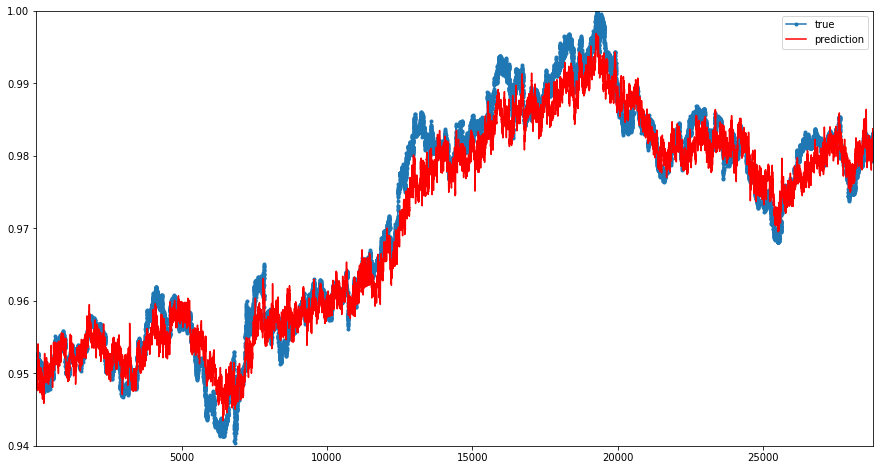

In [ ]:
#grafico de prediccion de test
plt.figure(figsize=(15,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.xlim(10,28785)
plt.ylim(0.940,1)
plt.legend()
plt.show()

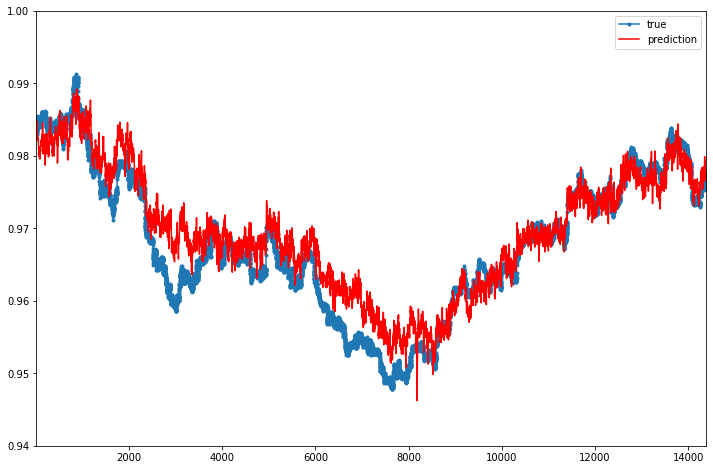

In [ ]:
#grafico de validacion de del set de validacion
plt.figure(figsize=(12,8))
plt.plot(y_val_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv_val.flatten(), 'r', label="prediction")
plt.xlim(10,14385)
plt.ylim(0.940,1)
plt.legend()
plt.show()

<Figure size 576x432 with 0 Axes>

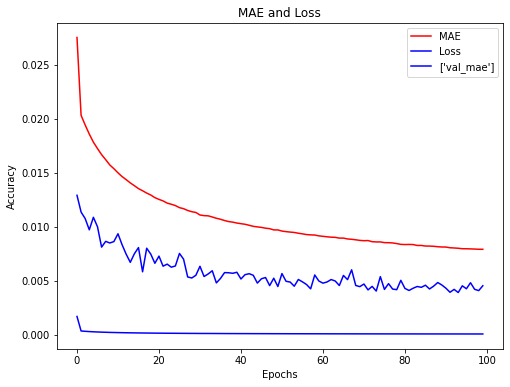

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de  la funciones de perdida y erro de entranamiento 
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']

epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_mae, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss",["val_mae"]])

plt.figure()

<Figure size 576x432 with 0 Axes>

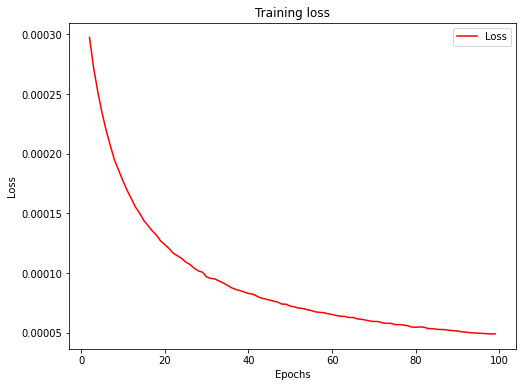

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de  la funciones de perdida y error de entranamiento 
zoomed_loss = loss[2:]
zoomed_val_mae =val_mae[2:]
zoomed_epochs = range(2,100)

#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r',label="loss")
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])


plt.figure()

In [ ]:
#modelo convolucional completamnte conectado a una capas LSTM
conv_model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=600, kernel_size=15,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[X_train.shape[1], X_train.shape[2]]),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(600, return_sequences=True)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(350, return_sequences=False)),
    # Shape => [batch, time, features]
  tf.keras.layers.Dense(units=1)
])

In [ ]:
#compilar el modelo y guardar los resultados del modelo LSTM
history2 = compile_and_fit(conv_model2, X_train, y_train, y_test)

val_performance={}
performance ={}
IPython.display.clear_output()

In [ ]:
#Predicciones en base a modelo convolucional
y_pred_conv = conv_model2.predict(X_test)
y_pred_test_conv = conv_model2.predict(X_val)

In [ ]:
#preparamos los datos que hemos predicho para hacer us graficas respectivas 
y_test_inv = y_test.reshape(1, -1)
y_pred_inv = y_pred_conv
y_val_inv = y_val.reshape(1, -1)
y_pred_inv_val = y_pred_test_conv

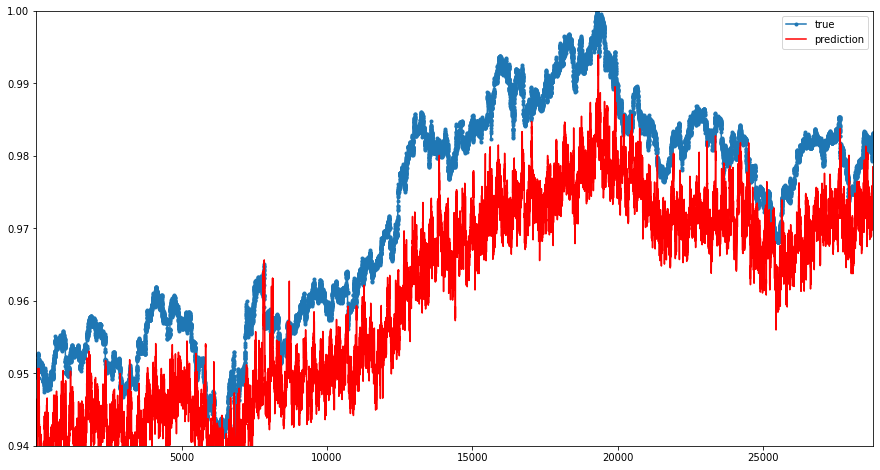

In [ ]:
#grafico de prediccion de test
plt.figure(figsize=(15,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.xlim(10,28785)
plt.ylim(0.940,1)
plt.legend()
plt.show()

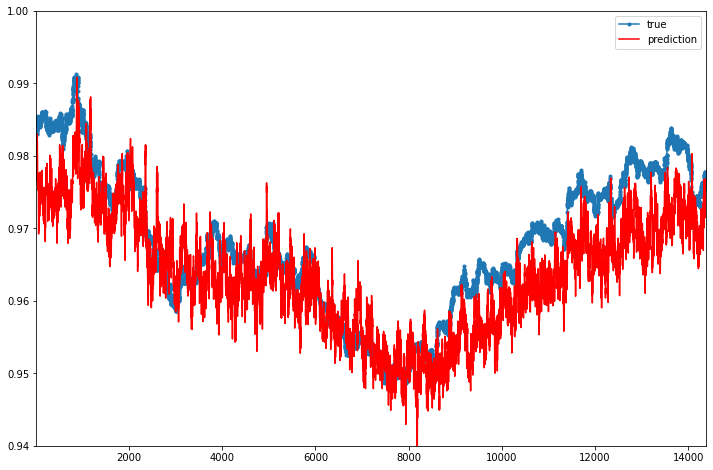

In [ ]:
#grafico de validacion de del set de validacion
plt.figure(figsize=(12,8))
plt.plot(y_val_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv_val.flatten(), 'r', label="prediction")
plt.xlim(10,14385)
plt.ylim(0.940,1)
plt.legend()
plt.show()

<Figure size 576x432 with 0 Axes>

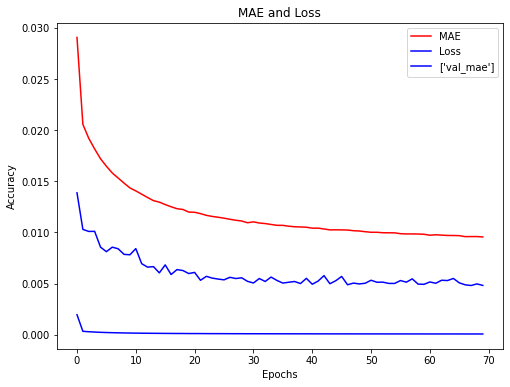

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de  la funciones de perdida y erro de entranamiento 
mae=history2.history['mae']
loss=history2.history['loss']
val_mae=history2.history['val_mae']

epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_mae, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss",["val_mae"]])

plt.figure()

<Figure size 576x432 with 0 Axes>

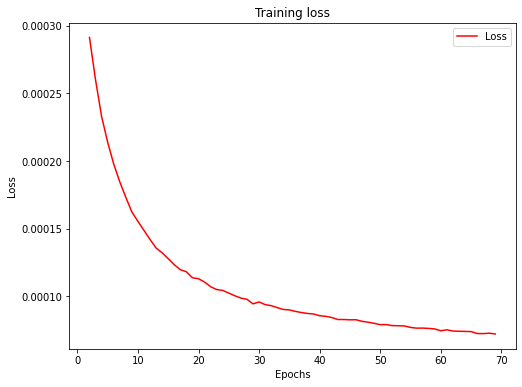

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de  la funciones de perdida y error de entranamiento 
zoomed_loss = loss[2:]
zoomed_val_mae =val_mae[2:]
zoomed_epochs = range(2,70)

#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r',label="loss")
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])


plt.figure()

In [ ]:
# MODELO DE CLARIFICACION DE LOS RETORNOS

In [ ]:
import numpy as np
df = df2[['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandhind','BID_CLOSE_eur_usd_5m_bolbandlind','BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandhind','BID_CLOSE_eur_sgd_5m_bolbandlind','BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandhind','BID_CLOSE_eur_gbp_5m_bolbandlind','BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandhind','BID_CLOSE_eur_hkd_5m_bolbandlind','BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandhind','BID_CLOSE_eur_cad_5m_bolbandlind','BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']]

df = df[80000:224000]
df.reset_index(inplace=True)
print(len(df))
df.head(5)

144000


,index,BID_CLOSE_eur_usd_5m,BID_CLOSE_eur_usd_5m_EWMA10,BID_CLOSE_eur_usd_5m_EWMA20,BID_CLOSE_eur_usd_5m_EWMA30,BID_CLOSE_eur_usd_5m_volume,BID_CLOSE_eur_usd_5m_moving_average,BID_CLOSE_eur_usd_5m_bolbandhind,BID_CLOSE_eur_usd_5m_bolbandlind,BID_CLOSE_eur_usd_5m_bolbandh,BID_CLOSE_eur_usd_5m_bol_bandl,BID_CLOSE_eur_usd_5m_RSI,BID_CLOSE_eur_usd_5m_EMA,BID_CLOSE_eur_sgd_5m,BID_CLOSE_eur_sgd_5m_EWMA10,BID_CLOSE_eur_sgd_5m_EWMA20,BID_CLOSE_eur_sgd_5m_EWMA30,BID_CLOSE_eur_sgd_5m_volume,BID_CLOSE_eur_sgd_5m_moving_average,BID_CLOSE_eur_sgd_5m_bolbandhind,BID_CLOSE_eur_sgd_5m_bolbandlind,BID_CLOSE_eur_sgd_5m_bolbandh,BID_CLOSE_eur_sgd_5m_bol_bandl,BID_CLOSE_eur_sgd_5m_RSI,BID_CLOSE_eur_sgd_5m_EMA,BID_CLOSE_eur_gbp_5m,BID_CLOSE_eur_gbp_5m_EWMA10,BID_CLOSE_eur_gbp_5m_EWMA20,BID_CLOSE_eur_gbp_5m_EWMA30,BID_CLOSE_eur_gbp_5m_volume,BID_CLOSE_eur_gbp_5m_moving_average,BID_CLOSE_eur_gbp_5m_bolbandhind,BID_CLOSE_eur_gbp_5m_bolbandlind,BID_CLOSE_eur_gbp_5m_bolbandh,BID_CLOSE_eur_gbp_5m_bol_bandl,BID_CLOSE_eur_gbp_5m_RSI,BID_CLOSE_eur_gbp_5m_EMA,BID_CLOSE_eur_hkd_5m,BID_CLOSE_eur_hkd_5m_EWMA10,BID_CLOSE_eur_hkd_5m_EWMA20,BID_CLOSE_eur_hkd_5m_EWMA30,BID_CLOSE_eur_hkd_5m_volume,BID_CLOSE_eur_hkd_5m_moving_average,BID_CLOSE_eur_hkd_5m_bolbandhind,BID_CLOSE_eur_hkd_5m_bolbandlind,BID_CLOSE_eur_hkd_5m_bolbandh,BID_CLOSE_eur_hkd_5m_bol_bandl,BID_CLOSE_eur_hkd_5m_RSI,BID_CLOSE_eur_hkd_5m_EMA,BID_CLOSE_eur_cad_5m,BID_CLOSE_eur_cad_5m_EWMA10,BID_CLOSE_eur_cad_5m_EWMA20,BID_CLOSE_eur_cad_5m_EWMA30,BID_CLOSE_eur_cad_5m_volume,BID_CLOSE_eur_cad_5m_moving_average,BID_CLOSE_eur_cad_5m_bolbandhind,BID_CLOSE_eur_cad_5m_bolbandlind,BID_CLOSE_eur_cad_5m_bolbandh,BID_CLOSE_eur_cad_5m_bol_bandl,BID_CLOSE_eur_cad_5m_RSI,BID_CLOSE_eur_cad_5m_EMA
0,80030,1.11784,1.117998,1.117693,1.117268,44.0,1.117840,0.0,0.0,1.118641,1.117038,57.406858,1.117907,1.53896,1.539561,1.539477,1.539398,317.0,1.539422,0.0,0.0,1.540277,1.538567,41.463364,1.539534,0.88327,0.883221,0.883063,0.882898,22.0,0.883131,0.0,0.0,0.883489,0.882772,59.969645,0.883159,8.76022,8.760772,8.760906,8.761058,43.0,8.760604,0.0,0.0,8.761959,8.759250,43.294066,8.760812,1.50617,1.506147,1.506210,1.506297,259.0,1.506080,0.0,0.0,1.506614,1.505547,47.856915,1.506158
1,80031,1.11767,1.117939,1.117691,1.117293,45.0,1.117864,0.0,0.0,1.118612,1.117116,54.319707,1.117875,1.53894,1.539448,1.539426,1.539369,183.0,1.539427,0.0,0.0,1.540269,1.538586,41.157264,1.539455,0.88327,0.883230,0.883083,0.882922,24.0,0.883144,0.0,0.0,0.883502,0.882786,59.969645,0.883173,8.75889,8.760430,8.760714,8.760918,21.0,8.760466,0.0,1.0,8.761925,8.759008,35.376877,8.760556,1.50654,1.506219,1.506241,1.506312,325.0,1.506109,0.0,0.0,1.506676,1.505542,54.712956,1.506209
2,80032,1.11772,1.117899,1.117694,1.117321,30.0,1.117904,0.0,0.0,1.118519,1.117289,55.084764,1.117854,1.53895,1.539358,1.539380,1.539342,232.0,1.539431,0.0,0.0,1.540264,1.538598,41.390246,1.539388,0.88309,0.883205,0.883083,0.882933,28.0,0.883145,0.0,0.0,0.883502,0.882787,53.533371,0.883162,8.75933,8.760230,8.760582,8.760815,14.0,8.760357,0.0,0.0,8.761814,8.758901,39.329675,8.760392,1.50684,1.506332,1.506298,1.506346,289.0,1.506148,1.0,0.0,1.506797,1.505500,59.376905,1.506293
3,80033,1.11772,1.117866,1.117696,1.117347,51.0,1.117927,0.0,0.0,1.118477,1.117376,55.084764,1.117837,1.53895,1.539283,1.539339,1.539317,155.0,1.539427,0.0,0.0,1.540268,1.538587,41.390246,1.539329,0.88316,0.883197,0.883091,0.882948,28.0,0.883143,0.0,0.0,0.883499,0.882786,55.532126,0.883162,8.75937,8.760073,8.760467,8.760722,10.0,8.760277,0.0,0.0,8.761764,8.758790,39.690829,8.760256,1.50670,1.506399,1.506337,1.506369,200.0,1.506172,0.0,0.0,1.506864,1.505481,56.454951,1.506347
4,80034,1.11779,1.117852,1.117705,1.117375,49.0,1.117930,0.0,0.0,1.118476,1.117384,56.273823,1.117830,1.53898,1.539228,1.539305,1.539295,196.0,1.539422,0.0,0.0,1.540272,1.538572,42.186679,1.539283,0.88307,0.883174,0.883089,0.882956,30.0,0.883144,0.0,0.0,0.883499,0.882788,52.410601,0.883150,8.75937,8.759945,8.760362,8.760635,14.0,8.760223,0.0

In [ ]:
df = df[['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']]
df_escalado = df

In [ ]:
#convertir el data frame en un arrray de numpy
df = df.values
df_ret=np.zeros((len(df[:-1,0]),len(df[0,:])))
for i in range(0,len(df[0,:])):
    df_ret[:,i] = np.log(df[1::,i]/df[0:-1,i])
columnas =['BID_CLOSE_eur_usd_5m','BID_CLOSE_eur_usd_5m_EWMA10','BID_CLOSE_eur_usd_5m_EWMA20','BID_CLOSE_eur_usd_5m_EWMA30','BID_CLOSE_eur_usd_5m_volume','BID_CLOSE_eur_usd_5m_moving_average',
          'BID_CLOSE_eur_usd_5m_bolbandh','BID_CLOSE_eur_usd_5m_bol_bandl','BID_CLOSE_eur_usd_5m_RSI','BID_CLOSE_eur_usd_5m_EMA',
          'BID_CLOSE_eur_sgd_5m','BID_CLOSE_eur_sgd_5m_EWMA10','BID_CLOSE_eur_sgd_5m_EWMA20','BID_CLOSE_eur_sgd_5m_EWMA30','BID_CLOSE_eur_sgd_5m_volume','BID_CLOSE_eur_sgd_5m_moving_average',
          'BID_CLOSE_eur_sgd_5m_bolbandh','BID_CLOSE_eur_sgd_5m_bol_bandl','BID_CLOSE_eur_sgd_5m_RSI','BID_CLOSE_eur_sgd_5m_EMA',
          'BID_CLOSE_eur_gbp_5m','BID_CLOSE_eur_gbp_5m_EWMA10','BID_CLOSE_eur_gbp_5m_EWMA20','BID_CLOSE_eur_gbp_5m_EWMA30','BID_CLOSE_eur_gbp_5m_volume','BID_CLOSE_eur_gbp_5m_moving_average',
          'BID_CLOSE_eur_gbp_5m_bolbandh','BID_CLOSE_eur_gbp_5m_bol_bandl','BID_CLOSE_eur_gbp_5m_RSI','BID_CLOSE_eur_gbp_5m_EMA',
          'BID_CLOSE_eur_hkd_5m','BID_CLOSE_eur_hkd_5m_EWMA10','BID_CLOSE_eur_hkd_5m_EWMA20','BID_CLOSE_eur_hkd_5m_EWMA30','BID_CLOSE_eur_hkd_5m_volume','BID_CLOSE_eur_hkd_5m_moving_average',
          'BID_CLOSE_eur_hkd_5m_bolbandh','BID_CLOSE_eur_hkd_5m_bol_bandl','BID_CLOSE_eur_hkd_5m_RSI','BID_CLOSE_eur_hkd_5m_EMA',
          'BID_CLOSE_eur_cad_5m','BID_CLOSE_eur_cad_5m_EWMA10','BID_CLOSE_eur_cad_5m_EWMA20','BID_CLOSE_eur_cad_5m_EWMA30','BID_CLOSE_eur_cad_5m_volume','BID_CLOSE_eur_cad_5m_moving_average',
          'BID_CLOSE_eur_cad_5m_bolbandh','BID_CLOSE_eur_cad_5m_bol_bandl','BID_CLOSE_eur_cad_5m_RSI','BID_CLOSE_eur_cad_5m_EMA']

df = pd.DataFrame(df_ret, columns=columnas)

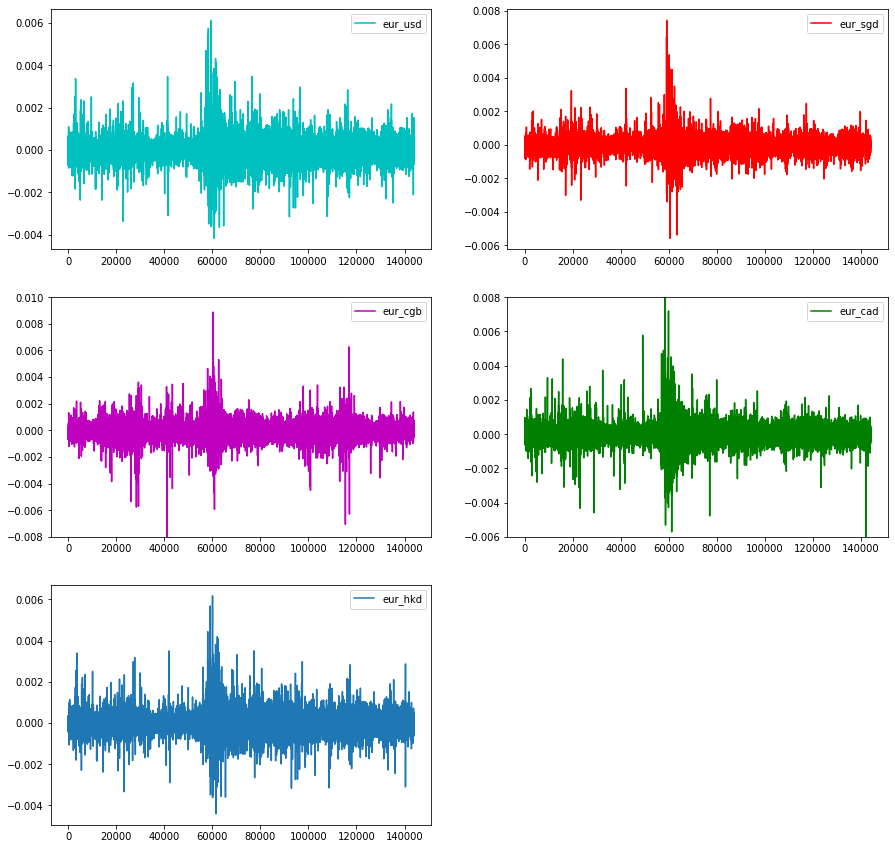

In [ ]:
#GRAFICO CON LOS RETORSNO DE CADA UNA DE LAS SERIES PRINCIPALES
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
plt.plot(df['BID_CLOSE_eur_usd_5m'],'c',label='eur_usd')
plt.legend()
  
plt.subplot(3, 2, 2)
plt.plot(df['BID_CLOSE_eur_sgd_5m'],'r',label='eur_sgd')
plt.legend()
  
plt.subplot(3, 2, 3)
plt.plot(df['BID_CLOSE_eur_gbp_5m'],'m',label='eur_cgb')
plt.ylim(-0.008,0.01)
plt.legend()
  
plt.subplot(3, 2, 4)
plt.plot(df['BID_CLOSE_eur_cad_5m'],'g',label='eur_cad')
plt.legend()
plt.ylim(-0.006,0.008)

plt.subplot(3, 2, 5)
plt.plot(df['BID_CLOSE_eur_hkd_5m'],label='eur_hkd')
plt.legend()  

plt.show()


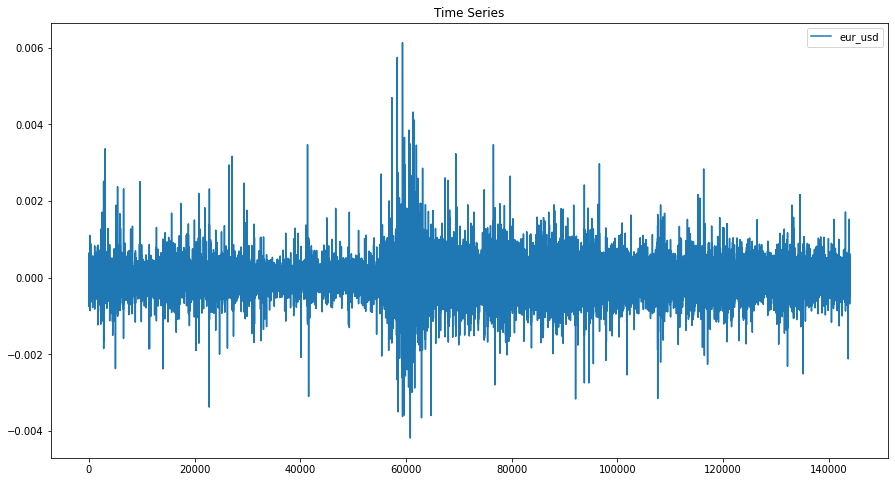

In [ ]:
#GRAFICO RETORNOS EUR_USD
plt.figure(figsize=(15,8))
plt.title(label="Time Series")
plt.plot(df['BID_CLOSE_eur_usd_5m'],label="eur_usd")
plt.legend()
plt.show()

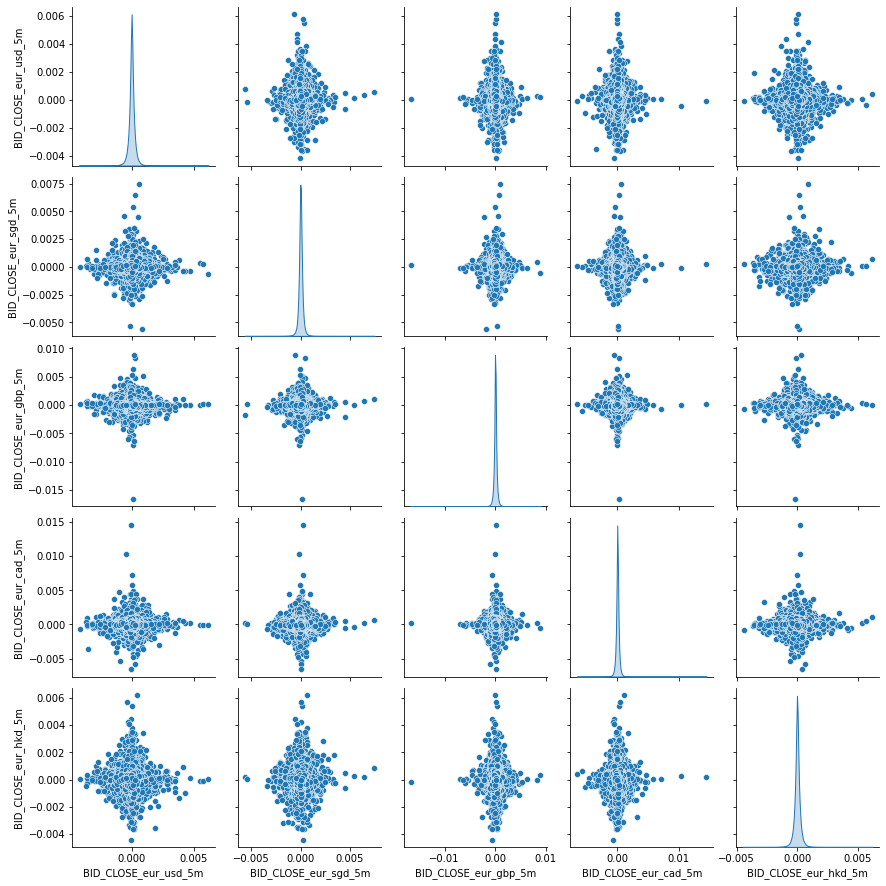

In [ ]:
#grafico descriptivo de las distribuciones de los retornos de los activos
sns.pairplot(df[["BID_CLOSE_eur_usd_5m", "BID_CLOSE_eur_sgd_5m", "BID_CLOSE_eur_gbp_5m", 
                 'BID_CLOSE_eur_cad_5m',"BID_CLOSE_eur_hkd_5m"]], diag_kind="kde")

In [ ]:
#estadsitica descritpiva de las series
df_describe =df[["BID_CLOSE_eur_usd_5m", "BID_CLOSE_eur_sgd_5m", "BID_CLOSE_eur_gbp_5m", 
                 'BID_CLOSE_eur_cad_5m',"BID_CLOSE_eur_hkd_5m"]]
df_describe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BID_CLOSE_eur_usd_5m,143999.0,5.254346e-07,0.000268,-0.004179,-0.000107,0.000000,0.000108,0.006133
BID_CLOSE_eur_sgd_5m,143999.0,2.774496e-07,0.000233,-0.005575,-0.000099,0.000000,0.000099,0.007435
BID_CLOSE_eur_gbp_5m,143999.0,-1.426614e-07,0.000327,-0.016586,-0.000125,0.000000,0.000127,0.008884
BID_CLOSE_eur_cad_5m,143999.0,-1.035405e-07,0.000291,-0.006540,-0.000116,0.000000,0.000117,0.014493
BID_CLOSE_eur_hkd_5m,143999.0,4.672426e-07,0.000269,-0.004410,-0.000108,0.000001,0.000110,0.006175


In [ ]:
#divisimos el set de datos general en train test y validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


print(n)
print(num_features)
print(len(train_df))
print(len(val_df))
print(len(test_df))

143999
50
100799
28800
14400


In [ ]:
time_steps = 15

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_df , train_df.BID_CLOSE_eur_usd_5m, time_steps)
X_test, y_test = create_dataset(val_df, val_df.BID_CLOSE_eur_usd_5m, time_steps)
X_val, y_val = create_dataset(test_df, test_df.BID_CLOSE_eur_usd_5m, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(100784, 15, 50) (100784,)
(28785, 15, 50) (28785,)
(14385, 15, 50) (14385,)


In [ ]:
#ctegorizacion de los intervalos para la clasificacion de los retornos
y_train_oneh = np.where((y_train > 0.00006), 2, y_train)
y_train_oneh = np.where(((y_train_oneh <= 0.00006) & (y_train_oneh >= -0.00003)), 1,y_train_oneh)
y_train_oneh = np.where((y_train_oneh < -0.00003), 0, y_train_oneh)
print(y_train_oneh[1:20])

y_test_oneh = np.where((y_test > 0.00006), 2, y_test)
y_test_oneh = np.where(((y_test_oneh <= 0.00006) & (y_test_oneh >= -0.00003)), 1,y_test_oneh)
y_test_oneh = np.where((y_test_oneh < -0.00003), 0, y_test_oneh)
print(y_test_oneh[1:20])

y_val_oneh = np.where((y_val > 0.00006), 2, y_val)
y_val_oneh = np.where(((y_val_oneh <= 0.00006) & (y_val_oneh>= -0.00003)), 1,y_val_oneh)
y_val_oneh= np.where((y_val_oneh < -0.00003), 0, y_val_oneh)
print(y_val_oneh[1:20])

[1. 0. 1. 0. 0. 1. 1. 2. 0. 0. 0. 2. 2. 2. 1. 1. 1. 0. 1.]
[0. 2. 0. 0. 2. 2. 1. 0. 0. 1. 0. 2. 1. 2. 0. 2. 2. 0. 0.]
[2. 1. 2. 0. 2. 0. 1. 2. 0. 1. 2. 1. 0. 0. 2. 2. 2. 0. 2.]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
## convertrir los datos de prediccion en one hot enconders para poder generar un algoritmo de calsificacion

#### train
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train_oneh)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_train_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(y_train_onehot_encoded[1:10])

#### test
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test_oneh)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_test_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(y_test_onehot_encoded[1:10])

#### validation
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_val_oneh)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_val_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(y_val_onehot_encoded[1:10])

[0 1 0 ... 0 0 2]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[1 0 2 ... 2 2 0]
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[2 2 1 ... 0 2 2]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [ ]:
#Mesclar los ejemplode manera aleatoria 
from sklearn.utils import shuffle
X_train,  y_train_onehot_encoded = shuffle(X_train, y_train_onehot_encoded, random_state=0)

In [ ]:
#nueva funcion de compilacion del modelom teniendo en cuenta que ahora es problema de calisificacion y por lo tnaot utlizaramos por ejemplo una funcion objetivo crossentropy para un problema multiclase

MAX_EPOCHS =70
from keras.optimizers import RMSprop

def compile_and_fit(model, X_train, y_train, y_test , patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor=['val_loss','val_acc'],
                                                    patience=patience,
                                                    mode='min')

#  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
 #    lambda epoch: 1e-8 * 10**(epoch / 20))
  #optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
  history = model.fit(X_train, y_train, 
                      batch_size=64,
#                      validation_data=(X_test, y_test),
                      verbose=1,
                      epochs=MAX_EPOCHS)#, callbacks=[lr_schedule])
  return history

In [ ]:
conv_model_clasi = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=550, kernel_size=15,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[X_train.shape[1], X_train.shape[2]]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(700, return_sequences=True)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(800, return_sequences=True)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(350, return_sequences=False)),
  tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
ytete =np.argmax(y_test_onehot_encoded,axis=1)
history3 = compile_and_fit(conv_model_clasi, X_train, y_train_onehot_encoded ,ytete)

val_performance={}
performance ={}
IPython.display.clear_output()
#val_performance['Conv'] = lstm_model.evaluate(y_train)
#performance['Conv'] = lstm_model.evaluate(y_test, verbose=0)

In [ ]:
#prediccion de la clasificacion en cada uno de los datao de
y_pred_train_conv_clasi = conv_model_clasi.predict(X_train)
y_pred_conv_clasi = conv_model_clasi.predict(X_test)
y_pred_test_conv_clasi = conv_model_clasi.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(np.argmax(y_train_onehot_encoded,axis=1), np.argmax(y_pred_train_conv_clasi,axis=1))
print(confusion)

confusion1 = confusion_matrix(np.argmax(y_test_onehot_encoded,axis=1), np.argmax(y_pred_conv_clasi,axis=1))
print(confusion1)

#confusion2 = confusion_mat

[[39634   453   572]
 [  162 25294   154]
 [  193   166 34156]]
[[4827 2472 4641]
 [2530 1587 2494]
 [4038 1960 4236]]


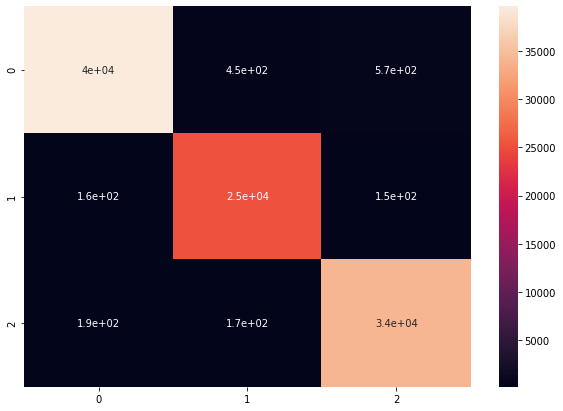

In [ ]:
#matrices de confucion en version grafico
import seaborn as sn
M1 = np.array(confusion)

M1
df_cm = pd.DataFrame(M1,)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
# confusion_matrix(M1)

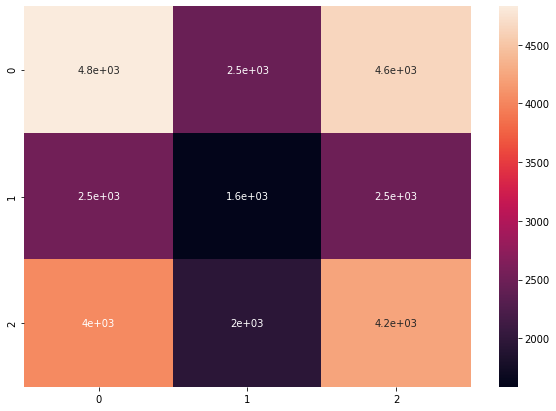

In [ ]:
#matrices de confucion en version grafico
import seaborn as sn
M2 = np.array(confusion1)

M1
df_cm = pd.DataFrame(M2,)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
# confusion_matrix(M1)

<Figure size 576x432 with 0 Axes>

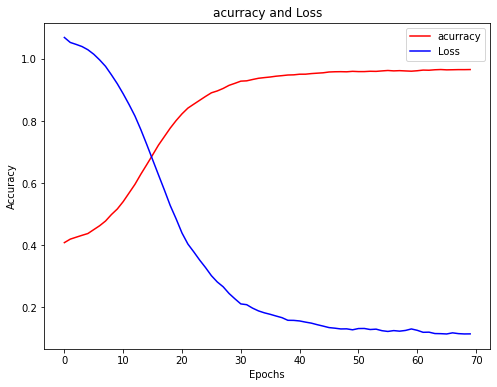

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de la acuracy del modelo
acurracy=history3.history['accuracy']
loss=history3.history['loss']


epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
plt.plot(epochs, acurracy, 'r')
plt.plot(epochs, loss, 'b')

plt.title('acurracy and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["acurracy", "Loss",["val_mae"]])

plt.figure()


<Figure size 576x432 with 0 Axes>

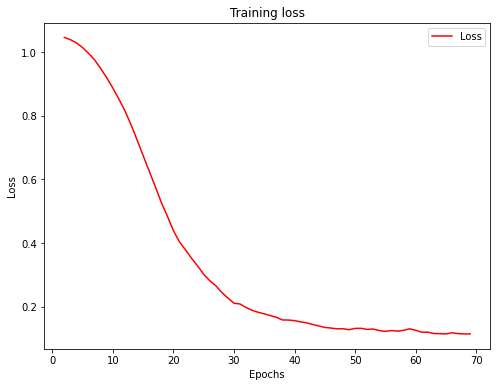

<Figure size 576x432 with 0 Axes>

In [ ]:
zoomed_loss = loss[2:]

zoomed_epochs = range(2,70)

#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r',label="loss")
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])


plt.figure()

In [ ]:
#modelos lstm de calsificacion
lstm_model_clasi = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(900, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))),
   tf.keras.layers.Dropout(0.4),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(600, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))),
   tf.keras.layers.Dropout(0.4),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(350, return_sequences=False)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
ytete =np.argmax(y_test_onehot_encoded,axis=1)
history4 = compile_and_fit(lstm_model_clasi, X_train, y_train_onehot_encoded ,ytete)

val_performance={}
performance ={}
IPython.display.clear_output()
#val_performance['Conv'] = lstm_model.evaluate(y_train)
#performance['Conv'] = lstm_model.evaluate(y_test, verbose=0)

In [ ]:
#prediccion de la clasificacion en cada uno de los datao de
y_pred_train_lstm_clasi = lstm_model_clasi.predict(X_train)
y_pred_lstm_clasi = lstm_model_clasi.predict(X_test)
y_pred_test_lstm_clasi = lstm_model_clasi.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion3 = confusion_matrix(np.argmax(y_train_onehot_encoded,axis=1), np.argmax(y_pred_train_lstm_clasi,axis=1))
print(confusion3)

confusion4 = confusion_matrix(np.argmax(y_test_onehot_encoded,axis=1), np.argmax(y_pred_lstm_clasi,axis=1))
print(confusion4)


[[40369   230    60]
 [   36 25559    15]
 [  351   114 34050]]
[[6053 2422 3465]
 [3161 1669 1781]
 [4933 2143 3158]]


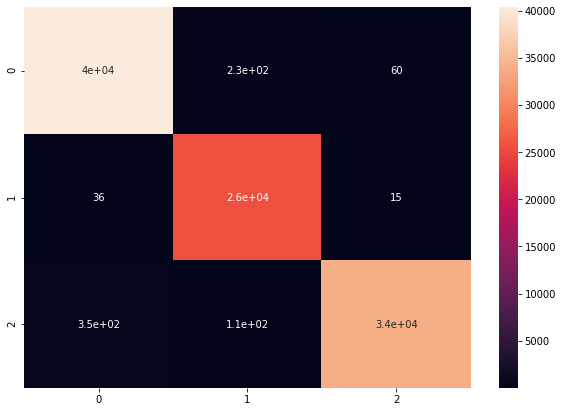

In [ ]:
#matrices de confucion en version grafico
import seaborn as sn
M3 = np.array(confusion3)

M3
df_cm = pd.DataFrame(M3,)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
# confusion_matrix(M1)

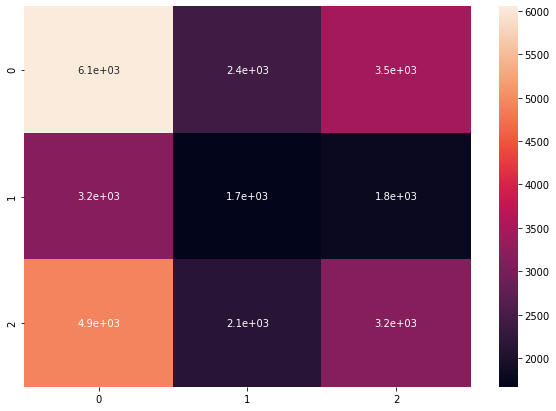

In [ ]:
#matrices de confucion en version grafico
import seaborn as sn
M4 = np.array(confusion4)

M4
df_cm = pd.DataFrame(M4,)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
# confusion_matrix(M1)

<Figure size 576x432 with 0 Axes>

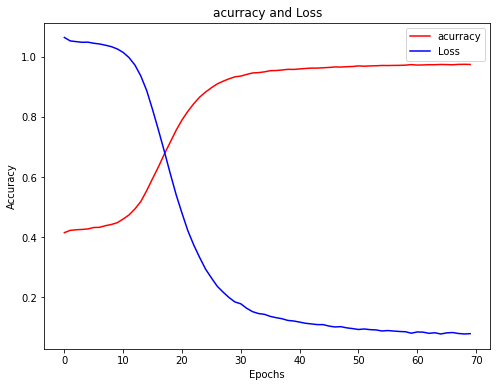

<Figure size 576x432 with 0 Axes>

In [ ]:
#grafico de la acuracy del modelo
acurracy=history4.history['accuracy']
loss=history4.history['loss']


epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
plt.plot(epochs, acurracy, 'r')
plt.plot(epochs, loss, 'b')

plt.title('acurracy and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["acurracy", "Loss",["val_mae"]])

plt.figure()


<Figure size 576x432 with 0 Axes>

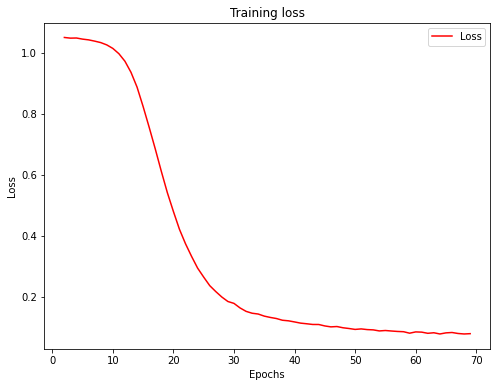

<Figure size 576x432 with 0 Axes>

In [ ]:
zoomed_loss = loss[2:]

zoomed_epochs = range(2,70)

#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r',label="loss")
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])


plt.figure()

In [ ]:
def algoritmo(y,y_pred,compra,venta,perdida_acumulada,base):
    
    #convertir pandas DataFrame en un numpy array
    y = y.to_numpy()
    y_pred = y_pred.to_numpy()
    #calcular los retornos logaritmicos de los rpecios reales
    y_ret =  np.array(np.log(y[1::]/y[0:-1]))
    #calcular los retornos logaritmicos de los precios predichos
    y_pred_ret = np.log(y_pred[1::]/y_pred[0:-1])
    
    #crear vectores de ceros para qeu tengan el mimos largo, ya que los retornos quitan una posicion
    y_ret2 = np.zeros((len(y),1))
    y_pred_ret2 = np.zeros((len(y),1))
    
    #el primer retorno se inicializada en cero para cada uno
    y_ret2[0]=0
    y_ret2[1::]= y_ret
    y_pred_ret2[0]= 0
    y_pred_ret2[1::]= y_pred_ret2
    
    #este es el vector que determina si hemos comprado el activo o no 0 para no lo ha comprado 1 para si 
    posicion = np.zeros((len(y),1))
    posicion[0]=0
    #este vector comprende el retorno total de las operaciones de trading
    resultado = np.zeros((len(y),1))
    resultado[0] =base
    #este vector contieje la informacion del retorno acumulado como se ha comprado el el activo
    ret_acumulado =np.zeros((len(y),1))
    ret_acumulado[0]=0
    
    #recorremos todos los precios para ver desempeño del algoritmo
    for i in range(1, len(y)):
        
        #si se ha comprado el activo se quiere calcular cual ha sido su retorno acumulado hasta un detmerinado momento
        if posicion[i-1] == 1:
            ret_acumulado[i] = ((1+y_pred[i-1])*(1+y_pred[i]))-1
        else:
            ret_acumulado[i] = 0
            
        
       #si no se ha comprado el activo y se predice una buena subida se compra el activo dado que no lo ha comprado 
        if (y_pred_ret2[i] >= compra and posicion[i-1] ==0):
            resultado[i]= resultado[i-1]*(1+ y_ret2[i])
            posicion[i] = 1
       #si se ha comprado el activo y se predice una buena subida no se hace nada dado que ya se ha comprado 
        elif (y_pred_ret2[i] >= compra and posicion[i-1] ==1):
            resultado[i]= resultado[i-1]*(1+ y_ret2[i])
            posicion[i] = posicion[i-1]
        #si se ha comprado el activo y se predice un retorno en la zona de no compra o venta no se hace nada se mantiene la inversion 
        elif (y_pred_ret2[i] > venta and y_pred_ret2[i] < compra and posicion[i-1] ==1):
            resultado[i]= resultado[i-1]*(1+ y_ret2[i])
            posicion[i] = posicion[i-1]
        #si se ha comprado el activo pero el precio predecido es muy negativo se vende inmediatamente o si la perdida acumulada e smuy grande  y posicion pasa a ser 0
        elif ((y_pred_ret2[i] <= venta and posicion[i-1] ==1) or (ret_acumulado[i-1] <= perdida_acumulada )):
            resultado[i]= resultado[i-1]
            posicion[i] = 0
        #si no se ha comprado el activo pero el precio predecido es muy negativo continua la posicion en  0
        elif (y_pred_ret2[i] <= venta and posicion[i-1] ==0):
            resultado[i]= resultado[i-1]*(1+ y_ret2[i])
            posicion[i] = 0
        #si se ha comprado el activo y se predice un retorno en la zona de no compra o venta no se hace nada se mantiene la inversion 
        elif (y_pred_ret2[i] > venta and y_pred_ret2[i] < compra and posicion[i-1] ==1):
            resultado[i]= resultado[i-1]*(1+ y_ret2[i])
            posicion[i] = posicion[i-1]
        else:
            print('caso atipico')
        
            

#------------------------------------------------
    plt.plot(resultado, 'r')
#    plt.plot(epochs, loss, 'b')
        
    plt.title('trading strategi')
    plt.xlabel("time")
    plt.ylabel("cumlative return")
    plt.legend(["strategu"])#, "Loss",["val_mae"]])   
    plt.figure()
      
        
    return resultado
        
    
a = algoritmo(y,y_pred,0.00006,-0.00007,0.00009,100)